In [1]:
import albumentations as A
from ultralytics import YOLO

In [2]:
transform = A.Compose([
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.5),
    A.ToGray(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)
], bbox_params=A.BboxParams(format='yolo'))

C:\Users\darsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\core\composition.py:243: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [3]:
import cv2
import matplotlib.pyplot as plt

In [4]:
img = cv2.imread("./cricket_ball_data/train/images/img_1262.jpg")

In [5]:
bbox = []
labels = [0,1]
with open("./cricket_ball_data/train/labels/img_1262.txt") as f:
    s = f.read()
    print(s)
    for i in s.split()[1:]:
        bbox.append(i)
    bbox.append(s[0])
    print(bbox)

0 0.464583 0.598148 0.019792 0.033333

['0.464583', '0.598148', '0.019792', '0.033333', '0']


In [6]:
import numpy as np

In [7]:
img = img
bbox = [list(map(float, bbox))]
img.shape

(1080, 1920, 3)

In [8]:
transformed = transform(image=img, bboxes=bbox)
image_t = transformed['image']
bbox_t = transformed['bboxes'][0]
image_t.shape, bbox_t

((1080, 1920, 3),
 [0.46458300948143005,
  0.598147988319397,
  0.019792020320892334,
  0.0333329439163208,
  0.0])

In [9]:
sp = (int((bbox_t[0] - bbox_t[2]) * image_t.shape[1]), int((bbox_t[1] - bbox_t[3]) * image_t.shape[0]))
ep = (int((bbox_t[0] + bbox_t[2]) * image_t.shape[1]), int((bbox_t[1] + bbox_t[3]) * image_t.shape[0]))
print(sp, ep)
i = cv2.rectangle(image_t, sp, ep, (255,255,255), 5)

(853, 610) (930, 681)


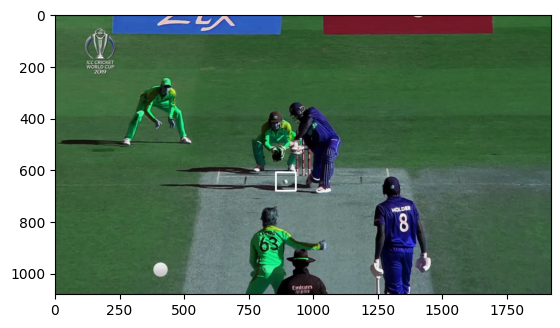

In [10]:
plt.imshow(i)

[0.464583, 0.598148, 0.019792, 0.033333, 0.0]


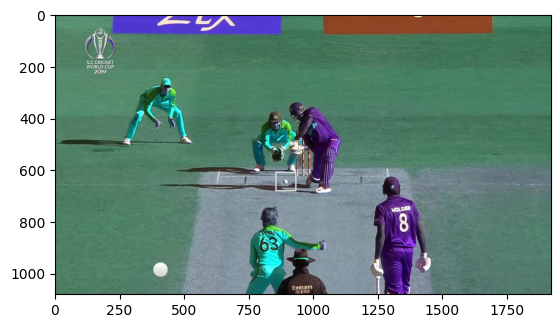

In [11]:
img = img
bbox = bbox[0]
print(bbox)
sp = (int((bbox[0] - bbox[2]) * img.shape[1]), int((bbox[1] - bbox[3]) * img.shape[0]))
ep = (int((bbox[0] + bbox[2]) * img.shape[1]), int((bbox[1] + bbox[3]) * img.shape[0]))
sp, ep
image = cv2.rectangle(img, sp, ep, (225,225,225), 3)
plt.imshow(img)

In [40]:
import uuid
import albumentations as A
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shutil
import os

In [41]:
DATA_PATH = os.path.join(os.getcwd(), 'cricket_ball_data')
OUTPUT_PATH = os.path.join(os.getcwd(), 'augmented_data')
NUMBER_AUGMENTATIONS = 20

In [42]:
os.path.exists(DATA_PATH), os.path.exists(OUTPUT_PATH)
if os.path.exists(OUTPUT_PATH):
    shutil.rmtree(OUTPUT_PATH)

In [43]:
os.mkdir(OUTPUT_PATH)

In [44]:
transform = A.Compose([
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [45]:
def read_yolo_labels(label_path):
    """Read YOLO format labels from a file."""
    with open(label_path, 'r') as f:
        labels = f.readlines()
    bboxes = []
    class_labels = []
    for label in labels:
        parts = label.strip().split()
        class_id = int(parts[0])
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])
        bboxes.append([x_center, y_center, width, height])
        class_labels.append(class_id)
    return bboxes, class_labels

In [46]:
def write_yolo_labels(label_path, bboxes, class_labels):
    """Write YOLO format labels to a file."""
    with open(label_path, 'w+') as f:
        for bbox, class_id in zip(bboxes, class_labels):
            x_center = round(bbox[0], 6)
            y_center = round(bbox[1], 6)
            width = round(bbox[2], 6)
            height = round(bbox[3], 6)
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

In [47]:
dt = ['train', 'test', 'valid']
for i in dt:
    image_path = os.path.join(os.path.join(DATA_PATH, i), 'images')
    label_path = os.path.join(os.path.join(DATA_PATH, i), 'labels')
    iter_list = []
    for file in os.listdir(image_path):
        file_name = os.path.splitext(os.path.basename(file))[0]
        if not os.path.exists(os.path.join(label_path, f"{file_name}.txt")):
            continue
        img = cv2.imread(os.path.join(image_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        bboxes, class_labels = read_yolo_labels(os.path.join(label_path, f"{file_name}.txt"))

        for k in range(NUMBER_AUGMENTATIONS):
            transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
            transformed_image = transformed['image']
            transformed_bboxes = transformed['bboxes']
            transformed_class_labels = transformed['class_labels']

            if not os.path.exists(os.path.join(os.path.join(OUTPUT_PATH, i), 'images')):
                os.makedirs(os.path.join(os.path.join(OUTPUT_PATH, i), 'images'), exist_ok=True)
            if not os.path.exists(os.path.join(os.path.join(OUTPUT_PATH, i), 'labels')):
                os.makedirs(os.path.join(os.path.join(OUTPUT_PATH, i), 'labels'), exist_ok=True)  

            uid = uuid.uuid4()
            output_file_path = os.path.join(os.path.join(os.path.join(OUTPUT_PATH, i), 'images'), f"{uid}.jpg")
            output_label_path = os.path.join(os.path.join(os.path.join(OUTPUT_PATH, i), 'labels'), f"{uid}.txt")
            cv2.imwrite(output_file_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
            write_yolo_labels(output_label_path, transformed_bboxes, transformed_class_labels)